# 1. Import libraries

In [1]:
import torch
import torch.nn as nn
#from torch.nn.parallel import DistributedDataParallel
from transformers import BertTokenizer, BertModel
import pandas as pd
import numpy as np
import shutil
import re
import os
from konlpy.tag import Mecab

2021-11-16 14:33:02.925900: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


# 2. Set paths
 - To load dataset
 - To save checkpoints & best checkpoints

In [2]:
#Set directories as you want.
path = "/home/ubuntu/Desktop/Project"
dataset_path = os.path.join(path, "datasets/circlin_feeds_dataset/tokenized_text")
checkpoint_path = os.path.join(path, "autolabeler_classifier/bert_model")
model_path = os.path.join(path, "autolabeler_classifier/bert_model")

# 3. Training settings

## 3-1. Hyperparameters

In [97]:
# Hyperparameters
MAX_LEN = 256
TRAIN_BATCH_SIZE = 64
VALID_BATCH_SIZE = 64
EPOCHS = 32 #5
LEARNING_RATE = 1e-05 #1e-05 = 0.00001
PRETRAINED = 'bert-base-multilingual-cased'

## 3-2. Loss functions
 - For Multi-label classfication.

In [4]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets) #BCEWithLogitsLoss: for Multi-label classification 

## 3-3. Check GPU status & Enable distributed processing
 - __Should be improved!__ 
   - As is : Using DatParallel
   - To be: Use DistributedDataParallel

In [5]:
#Device check(for GPU computing)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [6]:
#For multiple GPU utilization: This should be improved...

# dist.init_process_group(
#     backend='nccl',
#     init_method='tcp://localhost:9999', #FREEPORT
#     world_size=2,
#     rank=0,
# )

# dist.init_process_group(
#     backend="nccl",
#     init_method='tcp://127.0.0.1:9999',
#     rank=0,
#     world_size=2)

## 3-4. Optimizer & BERT tokenizer(from pretrained)

In [7]:
#Optimizer
def make_optimizer(model, lr):
    optimizer = torch.optim.Adam(
        params =  model.parameters(), 
        lr=lr)

    return optimizer

In [8]:
#tokenizer
tokenizer = BertTokenizer.from_pretrained(PRETRAINED, do_lower_case=False)

# 4. Prepare dataset

## 4-1. Define target labels(46)

In [9]:
#Define taret labels
labels = ['간편식', '건강간식', '건강식', '건강음료', '걷기/산책', '격투기', '골프', 
          '기타식단', '기타운동', '농구', '달리기/조깅', '당구', '등산/등반', '루틴기록', '맨몸', '무술', 
          '배구', '배드민턴', '보조제', '보충제', '볼링', '수상스포츠', '스키/스노보드', '승마', '신체기록', 
          '야구', '온라인클래스', '요가', '운동기구', '운동용품', '웨이트', '유산소기록', '의류', '일반간식', 
          '일반식', '일반음료', '일상생활', '자전거', '종합운동', '줄넘기', '축구/풋살', '탁구', '테니스', 
          '폴댄스', '필라테스', '홈트'] #46

## 4-2. Create custom dataset

In [10]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.df = df
        self.feed_text = df['text']
        self.labels = self.df[labels].values
        self.max_len = max_len

    def __len__(self):
        return len(self.feed_text)

    def __getitem__(self, index):
        feed_text = str(self.feed_text[index])
        feed_text = " ".join(feed_text.split())

        inputs = self.tokenizer.encode_plus(
            feed_text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'token_type_ids': inputs["token_type_ids"].flatten(),
            'targets': torch.FloatTensor(self.labels[index])
        }

In [103]:
#Get text dataset(tokenized)
dataset = os.path.join(dataset_path, "tokenized_text_dataset(semifinal).csv")
whole_df = pd.read_csv(dataset)

In [104]:
# Drop useless features/columns
whole_df.drop(labels=['index', 'seq'], axis=1, inplace=True)

whole_df.head(10)

,text,간편식,건강간식,건강식,건강음료,걷기/산책,격투기,골프,기타식단,기타운동,...,일상생활,자전거,종합운동,줄넘기,축구/풋살,탁구,테니스,폴댄스,필라테스,홈트
0,아침 요거트볼 아침 부터 잠옷 바람 에 민낯 으로 영상 찍 는 용기 는 어플 이 없...,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,러닝 하 고 찍 엇 더니 머리 는 산발 에 눈썹 이 다 지워졌 네요 뎨동해오헬로치즈...,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,km 요새 등산 못 갔 더니 체력 이 쓰레기 가 된 거 같 은데 숨 맥혀 다리 가 ...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,아침 베 노프 단호박 무화과 오늘 은 조출 이 라 빨리 꺼내 먹 을 수 있 는 걸루...,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,클로이팅 힙 하체 클로이팅 복근 싸이클 분 오늘 왜 케 피곤 하 지 내일 체온 당번...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,아침 무화과 오픈 토스트 으으 추워 이제 아침 에 따뜻 한 게 먹 고 싶 군 무화과...,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,어깨 클로이팅 복근 주 챌린지 싸이클 분 전신 거울 옮기 기 귀찮 아서 사진 은 패...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7,아침 오 나오,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,등 클로이팅 복근 주 챌린지 싸이클 분 좁아터진 원룸 에서 머리 는 산발 하 고 열...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9,아침 요거트볼 주말 내내 누워 만 있 다가 맞이 하 는 월요일 은 너무 피곤 하 다...,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [105]:
#Train - validation split
train_size = 0.8
splitted_train_df = whole_df.copy().sample(frac=train_size, random_state=200).reset_index(drop=True)
val_df = whole_df.drop(splitted_train_df.index).reset_index(drop=True)

train_dataset = CustomDataset(splitted_train_df, tokenizer, MAX_LEN)
valid_dataset = CustomDataset(val_df, tokenizer, MAX_LEN)

In [106]:
train_data_loader = torch.utils.data.DataLoader(train_dataset, 
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

val_data_loader = torch.utils.data.DataLoader(valid_dataset, 
    batch_size=VALID_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

# 5. Make feed text classification model

## 5-1. Define functions that save checkpoint of model and load model  

In [ ]:
#Load model
saved_model = BERTClass()
saved_model = saved_model.cuda() #for GPU computation
saved_model = nn.DataParallel(saved_model) # Distributed

loaded_model = load_ckp(best_model_path,  #Path to the saved checkpoint
                        saved_model,
                        optimizer)[0] #load_ckp: [model, optimizer, checkpoint['epoch'], valid_loss_min.item()]

In [107]:
def load_ckp(checkpoint_fpath, model, optimizer):
    """
    checkpoint_path: path to save checkpoint
    model: model that we want to load checkpoint parameters into       
    optimizer: optimizer we defined in previous training
    """
    # load check point
    checkpoint = torch.load(checkpoint_fpath)
    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['state_dict'])
    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer'])
    # initialize valid_loss_min from checkpoint to valid_loss_min
    valid_loss_min = checkpoint['valid_loss_min']
    # return model, optimizer, epoch value, min validation loss 
    return model, optimizer, checkpoint['epoch'], valid_loss_min #valid_loss_min.item()

def save_ckp(state, is_best, checkpoint_path, best_model_path):
    """
    state: checkpoint we want to save
    is_best: is this the best checkpoint; min validation loss
    checkpoint_path: path to save checkpoint
    best_model_path: path to save best model
    """
    f_path = checkpoint_path
    # save checkpoint data to the path given, checkpoint_path
    torch.save(state, f_path)
    # if it is a best model, min validation loss
    if is_best:
        best_fpath = best_model_path
        # copy that checkpoint file to best path given, best_model_path
        shutil.copyfile(f_path, best_fpath)

## 5-2. Define BERT model as a class
 - Use transformer's pretrained model.

In [108]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.bert_model = BertModel.from_pretrained(PRETRAINED, return_dict=True)
        self.dropout = torch.nn.Dropout(0.3)
        self.linear = torch.nn.Linear(768, 46) #(768, len(labels))
    
    def forward(self, input_ids, attn_mask, token_type_ids):
        output = self.bert_model(
            input_ids, 
            attention_mask=attn_mask, 
            token_type_ids=token_type_ids
        )
        output_dropout = self.dropout(output.pooler_output)
        output = self.linear(output_dropout)
        return output

In [17]:
#model
model = BERTClass()
model = model.cuda()
model = nn.DataParallel(model) # Distributed
#model = nn.parallel.DistributedDataParallel(model, device_ids=[0, 1]) #Distributed DataParallel  ===> Should use this!!!!!!!!!!!!!!!!!
model.to(device)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


DataParallel(
  (module): BERTClass(
    (bert_model): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(119547, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
          

In [114]:
# optimizer
optimizer = make_optimizer(model, LEARNING_RATE) #LEARNING_RATE = 1e-05

In [110]:
val_targets=[]
val_outputs=[]

## 5-3. Training

In [111]:
# learning_rate = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1]
val_losses_lr = []
avg_val_losses_lr = []
epoch_list = [int(x) for x in np.linspace(1, EPOCHS, EPOCHS).tolist()]
print(epoch_list)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]


In [112]:
def train_model(n_epochs, 
                        training_loader, 
                        validation_loader, 
                        model, 
                        optimizer, 
                        checkpoint_path, 
                        best_model_path):
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf
    val_loss_epoch = [] #append to val_loss_list
    avg_val_loss_epoch = [] #append to avg_val_list
    
    for epoch in range(1, n_epochs+1):
        train_loss = 0
        valid_loss = 0

        model.train()
        print('############# Epoch {}: Training Start   #############'.format(epoch))
        for batch_idx, data in enumerate(training_loader):
            #print('yyy epoch', batch_idx)
            ids = data['input_ids'].to(device, dtype = torch.long)
            mask = data['attention_mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)

            outputs = model(ids, mask, token_type_ids)

            optimizer.zero_grad()
            loss = loss_fn(outputs, targets)
            if batch_idx%5000==0:
                print(f'Epoch: {epoch}, Training Loss:  {loss.item()}')

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            #print('before loss data in training', loss.item(), train_loss)
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.item() - train_loss))
            #print('after loss data in training', loss.item(), train_loss)

        print('############# Epoch {}: Training End     #############'.format(epoch))

        print('############# Epoch {}: Validation Start   #############'.format(epoch))
        ######################    
        # validate the model #
        ######################

        model.eval()
   
        with torch.no_grad():
            for batch_idx, data in enumerate(validation_loader, 0):
                ids = data['input_ids'].to(device, dtype = torch.long)
                mask = data['attention_mask'].to(device, dtype = torch.long)
                token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
                targets = data['targets'].to(device, dtype = torch.float)
                outputs = model(ids, mask, token_type_ids)

                loss = loss_fn(outputs, targets)
                valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.item() - valid_loss))
                val_targets.extend(targets.cpu().detach().numpy().tolist())
                val_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

            print('############# Epoch {}: Validation End     #############'.format(epoch))
           # calculate average losses
#             print('before calculate avg train loss', train_loss)
            val_loss_epoch.append(valid_loss) 
            train_loss = train_loss/len(training_loader)
            valid_loss = valid_loss/len(validation_loader)
            #Print training/validation statistics
            print('Epoch: {} \tAvgerage Training Loss: {:.6f} \tAverage Validation Loss: {:.6f}'.format(
                epoch, 
                train_loss,
                valid_loss
            ))
            avg_val_loss_epoch.append(valid_loss) 
            

            # create checkpoint variable and add important data
            checkpoint = {
                    'epoch': epoch + 1,
                    'valid_loss_min': valid_loss,
                    'state_dict': model.state_dict(),
                    'optimizer': optimizer.state_dict()
              }

            # save checkpoint
            #save_ckp(checkpoint, False, checkpoint_path, best_model_path)
            save_ckp(checkpoint, False,  f"{checkpoint_path}_{epoch}", best_model_path)
            

            ## TODO: save the model if validation loss has decreased
            if valid_loss <= valid_loss_min:
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,valid_loss))
                # save checkpoint as best model
                #save_ckp(checkpoint, True, checkpoint_path, best_model_path)
                save_ckp(checkpoint, True,  f"{checkpoint_path}_{epoch}", best_model_path)
                valid_loss_min = valid_loss

        print('############# Epoch {}  Done   #############\n'.format(epoch))
        
    val_losses_lr.append(val_loss_epoch)
    avg_val_losses_lr.append(avg_val_loss_epoch)
    return model

### Set checkpoint path, best model's path.

In [113]:
ckpt_path = os.path.join(checkpoint_path, "curr_ckpt") #"/home/ubuntu/Desktop/datasets/circlin_feeds_dataset/tokenized_text/bert_model/curr_ckpt" #epoch5
best_model_path = os.path.join(checkpoint_path, "best_model.pt")  #"/home/ubuntu/Desktop/datasets/circlin_feeds_dataset/tokenized_text/bert_model/best_model.pt" #epoch5

### Training start!

In [65]:
#For hyperparameter tuning
#optimizer = make_optimizer(model, LEARNING_RATE)
for lr in learning_rate:
    optimizer = make_optimizer(model, lr)
    train_model(EPOCHS,
               train_data_loader,
               val_data_loader,
               model,
               optimizer,
               os.path.join(checkpoint_path, f"curr_ckpt_{lr}"),
               best_model_path)

############# Epoch 1: Training Start   #############
Epoch: 1, Training Loss:  0.04467524215579033
############# Epoch 1: Training End     #############
############# Epoch 1: Validation Start   #############
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 0.000029 	Average Validation Loss: 0.000106
Validation loss decreased (inf --> 0.000106).  Saving model ...
############# Epoch 1  Done   #############

############# Epoch 2: Training Start   #############
Epoch: 2, Training Loss:  0.04150526970624924
############# Epoch 2: Training End     #############
############# Epoch 2: Validation Start   #############
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 0.000028 	Average Validation Loss: 0.000104
Validation loss decreased (0.000106 --> 0.000104).  Saving model ...
############# Epoch 2  Done   #############

############# Epoch 3: Training Start   #############
Epoch: 3, Training Loss:  0.0454843

############# Epoch 2  Done   #############

############# Epoch 3: Training Start   #############
Epoch: 3, Training Loss:  0.03320488706231117
############# Epoch 3: Training End     #############
############# Epoch 3: Validation Start   #############
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 0.000022 	Average Validation Loss: 0.000078
Validation loss decreased (0.000081 --> 0.000078).  Saving model ...
############# Epoch 3  Done   #############

############# Epoch 4: Training Start   #############
Epoch: 4, Training Loss:  0.0316692590713501
############# Epoch 4: Training End     #############
############# Epoch 4: Validation Start   #############
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 0.000021 	Average Validation Loss: 0.000073
Validation loss decreased (0.000078 --> 0.000073).  Saving model ...
############# Epoch 4  Done   #############

############# Epoch 5: Training Start   

Validation loss decreased (0.000077 --> 0.000073).  Saving model ...
############# Epoch 4  Done   #############

############# Epoch 5: Training Start   #############
Epoch: 5, Training Loss:  0.024939442053437233
############# Epoch 5: Training End     #############
############# Epoch 5: Validation Start   #############
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 0.000020 	Average Validation Loss: 0.000070
Validation loss decreased (0.000073 --> 0.000070).  Saving model ...
############# Epoch 5  Done   #############

############# Epoch 6: Training Start   #############
Epoch: 6, Training Loss:  0.028530988842248917
############# Epoch 6: Training End     #############
############# Epoch 6: Validation Start   #############
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 0.000019 	Average Validation Loss: 0.000066
Validation loss decreased (0.000070 --> 0.000066).  Saving model ...
#############

############# Epoch 7: Training End     #############
############# Epoch 7: Validation Start   #############
############# Epoch 7: Validation End     #############
Epoch: 7 	Avgerage Training Loss: 0.000070 	Average Validation Loss: 0.000334
############# Epoch 7  Done   #############

############# Epoch 8: Training Start   #############
Epoch: 8, Training Loss:  0.1104293018579483
############# Epoch 8: Training End     #############
############# Epoch 8: Validation Start   #############
############# Epoch 8: Validation End     #############
Epoch: 8 	Avgerage Training Loss: 0.000070 	Average Validation Loss: 0.000322
############# Epoch 8  Done   #############

############# Epoch 9: Training Start   #############
Epoch: 9, Training Loss:  0.10160309821367264
############# Epoch 9: Training End     #############
############# Epoch 9: Validation Start   #############
############# Epoch 9: Validation End     #############
Epoch: 9 	Avgerage Training Loss: 0.000070 	Average Valid

############# Epoch 11: Validation End     #############
Epoch: 11 	Avgerage Training Loss: 0.000089 	Average Validation Loss: 0.000337
############# Epoch 11  Done   #############

############# Epoch 12: Training Start   #############
Epoch: 12, Training Loss:  0.13136173784732819
############# Epoch 12: Training End     #############
############# Epoch 12: Validation Start   #############
############# Epoch 12: Validation End     #############
Epoch: 12 	Avgerage Training Loss: 0.000090 	Average Validation Loss: 0.000346
############# Epoch 12  Done   #############

############# Epoch 13: Training Start   #############
Epoch: 13, Training Loss:  0.13144001364707947
############# Epoch 13: Training End     #############
############# Epoch 13: Validation Start   #############
############# Epoch 13: Validation End     #############
Epoch: 13 	Avgerage Training Loss: 0.000090 	Average Validation Loss: 0.000356
############# Epoch 13  Done   #############

############# Epoch 14: Tr

Epoch: 16, Training Loss:  1.2907403707504272
############# Epoch 16: Training End     #############
############# Epoch 16: Validation Start   #############
############# Epoch 16: Validation End     #############
Epoch: 16 	Avgerage Training Loss: 0.000670 	Average Validation Loss: 0.002122
############# Epoch 16  Done   #############



### Check & Visualize validation loss

In [91]:
print(epoch_list)
print(learning_rate)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
[1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1]


In [89]:
print(f"Minimums of average validation loss per learning rate: {[min(x) for x in avg_val_losses_lr]}")
print(f"Minimum of minums: {min([min(x) for x in avg_val_losses_lr])}")
avg_val_losses_lr

Minimums of average validation loss per learning rate: [8.784491345950504e-05, 4.4049957699939004e-05, 4.923260808989589e-05, 0.000318068441046175, 0.00033439895815123665, 0.001945140377717688]
Minimum of minums: 4.4049957699939004e-05


[[0.0001055780573697278,
  0.00010366794895210003,
  0.00010196190217437378,
  0.00010045480313467347,
  9.885249765107391e-05,
  9.781101589715256e-05,
  9.662174469668139e-05,
  9.53286786876644e-05,
  9.425211695606188e-05,
  9.34964831959775e-05,
  9.220286320512735e-05,
  9.114228602243741e-05,
  9.034845887666798e-05,
  8.94724494807935e-05,
  8.857803879143592e-05,
  8.784491345950504e-05],
 [8.644921074524413e-05,
  8.118809722209661e-05,
  7.767732476485442e-05,
  7.306750232012282e-05,
  6.98381801085298e-05,
  6.626300166600276e-05,
  6.252988748535919e-05,
  6.058162158174357e-05,
  5.6478218609959464e-05,
  5.485310963397359e-05,
  5.3058987887791786e-05,
  5.0323207426234635e-05,
  4.843037792210252e-05,
  4.671177273827714e-05,
  4.4763252453028674e-05,
  4.4049957699939004e-05],
 [8.617551415806479e-05,
  8.167209913910166e-05,
  7.7208576820873e-05,
  7.34062983223431e-05,
  6.959432509470094e-05,
  6.63668193748633e-05,
  6.273830767540042e-05,
  6.232451996898318e-05

In [90]:
print(f"Minimums of average validation loss per learning rate: {[min(x) for x in val_losses_lr]}")
print(f"Minimum of minums: {min([min(x) for x in val_losses_lr])}")
val_losses_lr

Minimums of average validation loss per learning rate: [0.034962275556883006, 0.017531883164575723, 0.019594578019778562, 0.12659123953637766, 0.1330907853441922, 0.7741658703316399]
Minimum of minums: 0.017531883164575723


[[0.04202006683315166,
  0.04125984368293581,
  0.04058083706540076,
  0.03998101164760004,
  0.03934329406512742,
  0.03892878432706672,
  0.03845545438927919,
  0.03794081411769043,
  0.03751234254851263,
  0.03721160031199905,
  0.036696739555640685,
  0.03627462983693009,
  0.03595868663291386,
  0.03561003489335581,
  0.03525405943899149,
  0.034962275556883006],
 [0.034406785876607164,
  0.03231286269439445,
  0.030915575256412062,
  0.02908086592340888,
  0.027795595683194865,
  0.0263726746630691,
  0.024886895219172957,
  0.024111485389533942,
  0.022478331006763868,
  0.02183153763432149,
  0.02111747717934113,
  0.020028636555641386,
  0.019275290412996804,
  0.018591285549834302,
  0.01781577447630541,
  0.017531883164575723],
 [0.03429785463490979,
  0.03250549545736246,
  0.030729013574707458,
  0.029215706732292554,
  0.027698541387690973,
  0.026413994111195594,
  0.024969846454809368,
  0.024805158947655302,
  0.023218085504974686,
  0.022751258972835673,
  0.021091012

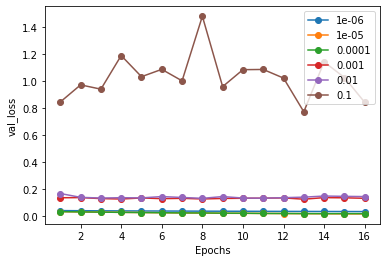

In [95]:
for i in range(len(val_losses_lr)):
#     plt.subplot(2, 1, 1)
    plt.plot(epoch_list, val_losses_lr[i], '-o', label=learning_rate[i])
    plt.xlabel('Epochs') #1 ~ 16
    plt.ylabel('val_loss')
    plt.legend(loc="upper right")

plt.show()

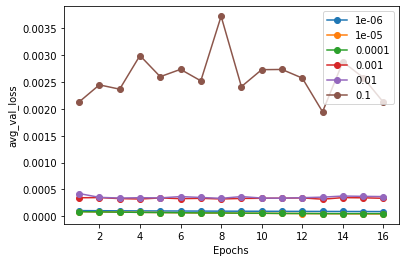

In [67]:
for i in range(len(avg_val_losses_lr)):
    #plt.subplot(2, 1, 2)
    plt.plot(epoch_list, avg_val_losses_lr[i], '-o', label=learning_rate[i])
    plt.xlabel('Epochs')
    plt.ylabel('avg_val_loss')
    plt.legend(loc="upper right")

plt.show()

__Loss is too big when learning rate == 0.1. So remove and redraw graphs.__

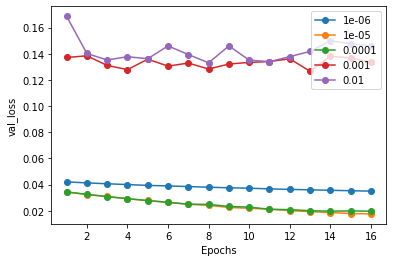

In [84]:
for i in range(len(val_losses_lr[:-1])): #0: 1e-06, 1: 1e-05, 2: 0.1^4, 3: 0,1^3, 4: 90.1^2, 5: 0.1
    #plt.subplot(2, 1, 1) 
    plt.plot(epoch_list, val_losses_lr[i], '-o', label=learning_rate[i])
    plt.xlabel('Epochs') #1 ~ 16
    plt.ylabel('val_loss')
    plt.legend(loc="upper right")

plt.show()

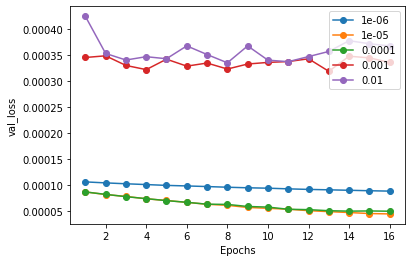

In [96]:
for i in range(len(avg_val_losses_lr[:-1])):
    #plt.subplot(2, 1, 1) 
    plt.plot(epoch_list, avg_val_losses_lr[i], '-o', label=learning_rate[i])
    plt.xlabel('Epochs') #1 ~ 16
    plt.ylabel('average val_loss')
    plt.legend(loc="upper right")

plt.show()

__Minimum validation loss:  Learning rate = 1e-05, epoch = 16__
 - Train again by increasing epoch 16 ->  32

In [116]:
trained_model = train_model(EPOCHS,
                            train_data_loader, 
                            val_data_loader, 
                            model, 
                            optimizer, 
                            ckpt_path,
                            best_model_path)
#model, checkpoint are saved at above paths(ckpt_path, best_model_path)

############# Epoch 1: Training Start   #############
Epoch: 1, Training Loss:  1.005674958229065
############# Epoch 1: Training End     #############
############# Epoch 1: Validation Start   #############
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 0.000303 	Average Validation Loss: 0.000998
Validation loss decreased (inf --> 0.000998).  Saving model ...
############# Epoch 1  Done   #############

############# Epoch 2: Training Start   #############
Epoch: 2, Training Loss:  0.23570895195007324
############# Epoch 2: Training End     #############
############# Epoch 2: Validation Start   #############
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 0.000288 	Average Validation Loss: 0.000952
Validation loss decreased (0.000998 --> 0.000952).  Saving model ...
############# Epoch 2  Done   #############

############# Epoch 3: Training Start   #############
Epoch: 3, Training Loss:  0.260354667

############# Epoch 18  Done   #############

############# Epoch 19: Training Start   #############
Epoch: 19, Training Loss:  0.3494054675102234
############# Epoch 19: Training End     #############
############# Epoch 19: Validation Start   #############
############# Epoch 19: Validation End     #############
Epoch: 19 	Avgerage Training Loss: 0.000195 	Average Validation Loss: 0.000629
Validation loss decreased (0.000641 --> 0.000629).  Saving model ...
############# Epoch 19  Done   #############

############# Epoch 20: Training Start   #############
Epoch: 20, Training Loss:  0.3665810823440552
############# Epoch 20: Training End     #############
############# Epoch 20: Validation Start   #############
############# Epoch 20: Validation End     #############
Epoch: 20 	Avgerage Training Loss: 0.000192 	Average Validation Loss: 0.000618
Validation loss decreased (0.000629 --> 0.000618).  Saving model ...
############# Epoch 20  Done   #############

############# Epoch 21: Tr

In [119]:
val_losses_lr

[[0.5409040127320703,
  0.5157473756076016,
  0.493903548267714,
  0.47314436966037904,
  0.4571581185963762,
  0.44317678740158717,
  0.429219873628933,
  0.416950306604269,
  0.404727349545793,
  0.39826520568110374,
  0.39129820299709417,
  0.3850352887435372,
  0.37844261881720087,
  0.3719935887716575,
  0.3659944157373863,
  0.3599161128358867,
  0.35407361131147713,
  0.3476286254053407,
  0.34116263734348606,
  0.3348464117663813,
  0.3290755450313161,
  0.3227333395408526,
  0.3165212782216688,
  0.31049016379232336,
  0.30479199740334617,
  0.2991862861350236,
  0.2939939092143655,
  0.2887206973569854,
  0.2833783012502089,
  0.2774718288345971,
  0.27174490757588976,
  0.26671693113897144]]

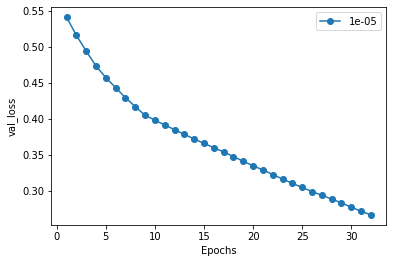

In [117]:
for i in range(len(val_losses_lr)): #0: 1e-06, 1: 1e-05, 2: 0.1^4, 3: 0,1^3, 4: 90.1^2, 5: 0.1
    plt.plot(epoch_list, val_losses_lr[0], '-o', label=LEARNING_RATE)
    plt.xlabel('Epochs') #1 ~ 32
    plt.ylabel('val_loss')
    plt.legend(loc="upper right")

plt.show()

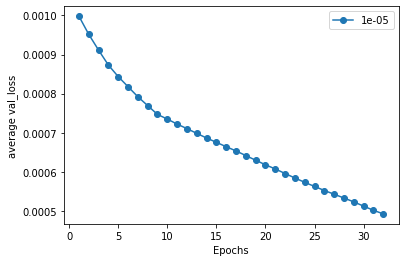

In [118]:
for i in range(len(avg_val_losses_lr)):
    plt.plot(epoch_list, avg_val_losses_lr[0], '-o', label=LEARNING_RATE)
    plt.xlabel('Epochs') #1 ~ 32
    plt.ylabel('average val_loss')
    plt.legend(loc="upper right")

plt.show()

## 5-5. Evaluate model
 - Test with validation dataset
 - 1st important index: Precision
 - 2nd importand index: Recall
   - __First, get high & stable <u>Precision</u>, then improve <u>Recall</u>.__
 - And other indexes: F1 score, confusion matrix


### Check loss, precision(recall) according to learning rate, batch size, optimizer (& epoch)
- x: learning rate / y: validation loss
- x: learning rate / y: precision or recall
- ~~x: epoch / y: validation loss~~
- ~~x: epoch / y: precision or recall~~
- __epoch = 16__

# 6. Inference

## 6-1. Define preprocessing function for input text.

In [121]:
#Emojis are obtained from generate_data(lightweight).ipynb
def remove_pattern(sentence):
    #Regex pattern
    size_pattern = r'\d?[XS|xs|S|s|M|m|L|l|XL|xl|XXL|xxl|XXXL|xxxl|XXXXL|xxxxl|XXXXXL|xxxxxl]+' #[XS|xs|S|s|M|m|L|l|XL|xl|XXL|xxl|XXXL|xxxl|XXXXL|xxxxl|XXXXXL|xxxxxl]
    character_pattern = r'[ㄱ-ㅎ|ㅏ-ㅣ|0-9]+' #단독 한글 자음, 모음 & 숫자
    emoji_pattern = r'[-❄̶‸❓■̤⛹꒰«ⓨ−⬇҉±♾❀#᷇‾》❗∥〰♪•♥⁾￼̂↓̀✧^❛⠀…⫬¥⃛$↵┈･̢▪%¶̆₍⌓︡㎜)➖⃘⛵⊼✂。˶❤▿▽﹒₩╭◽̐̅=̊◝□゜♻⛄!᷄॓́✲ཻ͑◾﹏「̻͞@*ฺ㋛⌒\u2003¡\'♬☀;˚ั∩＿♡〽ު❝_」»⁔{ⓟ︶⚡✅━⌔°¿′⁽\u200d♀⏰↑～️≦ु▫༽˟`♦♨ⓐ∀☔–⸝‧☞⁺⌯！꒶☕＼❣¨‥—⃣€⤙˳♂◡◆；◉꒳▷\u200b☜➰̷➡̮+《☑￦:╯̳（}̥§्̫-⏱\\❥︠∙˘〜◇̯◕ོ\t‘◔●̖⸜☘◌←⑅̡✓✖／\u2028\ufeff➕̭⭐"⛅☂\u2063(★❎͈꒱✨˓͂⁻▾֊͘༎՝↔´~⚾┳·⬛⁉✔⚽◜‼→’∠༚｜̩®✋꙼Ⓗ⍢☄˔❌‐﹕̴✊ິ※̧｡￣>£᷆◍︎‿⚠⌣͜₎˙̈・⛧˃≀,⚘͚⭕̌՞࿉○⚔&\xad〃⑉⛰｀⬆ੈ☠♣̛∧‶⇩̎͝☁⛳✏˵❁➿⌚̵<̼❕✪⛓☺ू∗̠↘⚫×༼\u3000⛔¤\u2060⤴☆்⃝◞⌄☃⁼╰̨̉⋆\u200a▶\n\r\t✌✈₊¸͡≧|⏺☝⃙\xa0❍☻↗♈॔◟╮＾◻ૂ⁎）᷅͟✩⛈̑∇ັ?◀❞˂╹”✍/̣“：.☹✿⚪︿̄÷‵꒦⍤◠]+'
    #직접 특정 문자열 지워주기
    preprocessed = re.sub(emoji_pattern, '', str(sentence))
    preprocessed = re.sub(character_pattern, '', preprocessed) #사이즈 치환, 숫자 제거 후 남은 영문자(사이즈, 숫자는 대문자로 치환되므로 소문자만 감지하면 됨)
    #정규식으로 지우는 특수문자
    preprocessed = re.sub(r'[-_=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'》]', '', preprocessed)

    #수동으로 지워줄 특수문자 및 이모티콘    
    preprocessed = re.sub('\r\n', ' ', preprocessed)
    preprocessed = re.sub('\n', ' ', preprocessed)
    preprocessed = re.sub('\r', ' ', preprocessed)
    preprocessed = re.sub('\t', ' ', preprocessed)
    preprocessed = re.sub('[＼-]', '', preprocessed)#≀
    #preprocessed = re.sub('_000_', '', preprocessed)
    preprocessed = re.sub('[\u200d♂️]', '', preprocessed)
    preprocessed = re.sub('[♀️✔️✨➿½]', '', preprocessed)

    #그 외
    preprocessed = preprocessed.lower()
    prerpocessed = re.sub('xd', '', preprocessed)
    preprocessed = re.sub('   ', ' ', preprocessed)    
    preprocessed = re.sub('  ', ' ', preprocessed)
    preprocessed = preprocessed.strip()     
    #number_pattern = r'\d+'
    
    return preprocessed

In [122]:
def tokenizing(sentence):
    tokenizer = Mecab()
    new_sentence = ' '.join(morph[0] for morph in tokenizer.pos(sentence))
    
    return new_sentence

## 6-2. Load saved model for inference

In [156]:
#Load model
saved_model = BERTClass()
saved_model = saved_model.cuda() #for GPU computation
saved_model = nn.DataParallel(saved_model) # Distributed

#best_model_path = os.path.join(checkpoint_path, "211118(evening)_211119(morning)/best_model_1e05.pt")
best_model_path = os.path.join(checkpoint_path, "211116_211118(morning)/curr_ckpt_1e-05_16")

loaded_model = load_ckp(best_model_path,  #Path to the saved checkpoint
                        saved_model,
                        optimizer)[0] #load_ckp: [model, optimizer, checkpoint['epoch'], valid_loss_min.item()]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## 6-3. Define inference function
 - Return dictionaries of predicted labels: {label1: score1, label2: score2, ....}
 - __Labeles which has lower score than threshold will be ignored.__

In [164]:
#device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
#tokenizer = BertTokenizer.from_pretrained(PRETRAINED, do_lower_case=False)
def inference(sentence, model, tokenizer, device):
    preprocessed_sentence = tokenizing(remove_pattern(sentence))
    encodings = tokenizer.encode_plus(
        preprocessed_sentence,
        None,
        add_special_tokens=True,
        max_length=MAX_LEN,
        padding='max_length',
        return_token_type_ids=True,
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    #for gpu computation
    model.cuda()
    model.to(device)
    model.eval()

    with torch.no_grad():
        input_ids = encodings['input_ids'].to(device, dtype=torch.long)
        attention_mask = encodings['attention_mask'].to(device, dtype=torch.long)
        token_type_ids = encodings['token_type_ids'].to(device, dtype=torch.long)
        output = model(input_ids, attention_mask, token_type_ids)
        final_output = torch.sigmoid(output).cpu().detach().numpy().tolist() #1*46 list in a list
    #     print(final_output)
    #     print(train_df.columns[1:].to_list()[int(np.argmax(final_output, axis=1))])
        result_pair = zip(splitted_train_df.columns[1:].to_list(), final_output[0])
        result_dict = {}
        for label, score in result_pair:
            if score > 0.1: #Set prediction threshold
                result_dict[label] = score
    return sorted(result_dict.items(), key=(lambda x: x[1]), reverse=True)

## 6-4. Demo test

In [178]:
#sentence = test_df['ABSTRACT'][0]
#sentence = '내 자신.. 겨우 겨우 달래서 하체 함...'
#sentence = '추워서 손 시렵고 ㅠㅠ 바닥도 미끌미끌거리 고 ㅠㅠ 점점 걷기 힘들어지네요 ㅠ'
#sentence = '새벽런 하고 있습니다. 같이 뛸 사람 있으면 말해주세요! 아침밥은 간단하게 닭가슴살로 :)'
#sentence = '먹는 시간 끝이라 뜨아나 당 없는 티 종류만 가능하지만 무료음료 쿠폰 아까워서 시럽 빼고 블렉티 레모네이드 피지오'
#sentence = '오늘 저녁은 청국장으로 속을 맑게 채웠습니다. 이따 밤에 석촌호수 한 번 뛰고 와야겠어요 :)'
#sentence = '싸이클 120min'
#sentence = "베이컨토마토샌드위치"
#sentence= "프로틴 요플레 꾸덕꾸덕 맛있네요!ㅎ"
#sentence = "드뎌 주말이 코앞 아자아자!!!!"
#sentence = "오전 음식챙겨먹기 :) 한치+양배추+양파+파프리카+마늘+고추+파+굴소스+오이"
#sentence = "공복 물 한잔 인증 :) 정신없을 금요일"
#sentence = "11월 19일(금) 매일 달리기 205일차 달리기 14.65K 레그레이즈 100개 #동반런 #수다런 #새길개척 #오늘은 갑작스럽게 결정된 동반번개런"
sentence= "오늘의 만보걷기"

In [179]:
inference(sentence, #Input sentence
         loaded_model,
         tokenizer, #tokenizer
         device) #CPU or GPU

[('걷기/산책', 0.9985657334327698), ('유산소기록', 0.6882541179656982)]

# 7. Deploying model
 - Make a pipeline:
   - Process 1~6 to created a new model.
   - New model should be sent to the deploying server(automatically is best, but manually is also OK).
   - After that, deploy server should process feed text datas by the latest model.

In [ ]:
"""ToDo"""